# DCR Research - Assingment 3
Astronomy 499: (Winter 2022)

In [1]:
import numpy as np
import scipy.constants as const
import matplotlib
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.units import cds
cds.enable()
import pandas as pd

## From Previous Assignments 

In [2]:
latitude = -30.24463 * u.deg
longitude = -70.74942 * u.deg
altitude = 2647 * u.m
p0 = 101325 * u.Pa # sea level air presssure
g = const.g * (u.m/u.s**2)
R0 = 8.31447 * u.J/(u.mol*u.K) # gas constant
T0 = 19. * u.deg_C # typical sea level temperature
lapseRate = -6.5 * (u.deg_C/u.km) # typical rate of change of temperature with altitude
M = 0.0289644 * (u.kg/u.mol) # molar mass of dry air
humidity = 40. # typical humidity at many ovservatory sites

In [3]:
temperature = T0 + (lapseRate * altitude)
temperatureK = temperature.to(u.K, equivalencies = u.temperature())

pressure = (p0 * np.exp((-g * M * altitude) / (R0 * temperatureK))).to(u.Pa)

In [4]:
# calculating the water-vapor pressure (mm)
def power_vapor_pressure(temp, RH):
    t = temp.value
    x = np.log(RH/100)
    tdC_numerator = (((t + 238.3)*x) + (17.2694 * t))
    tdC_demoninator = ((t + 238.3) * (17.2694 - x)) - (17.2694 * t)
    tdC = (238.3 * (tdC_numerator/tdC_demoninator)) * u.deg_C
    t_dewpoint_C = tdC.value
    pressure = (4.50874 + (0.341724 * t_dewpoint_C) + (0.0106778 * t_dewpoint_C**2) + (0.184889e-3 * t_dewpoint_C**3) + (0.238294e-5 * t_dewpoint_C**4) + (0.203447e-7 * t_dewpoint_C**5)) * u.cds.mmHg
    return pressure

p_w = (power_vapor_pressure(temperature, humidity)).to(u.cds.mbar)
p_s = pressure.to(u.cds.mbar)
zin = 30 * u.deg

In [5]:
# Using Equations: 4, 5, 9, 10, 14, 15, 16, 18, 20, 21 + 2

def gammafunction(wavelength, Ps_in, Tinitial, Pw_in):
    T = Tinitial.to(u.K, equivalencies = u.temperature()).value
    sigma = 1/wavelength.to(u.um).value
    
    Ps = Ps_in.to(u.cds.mbar).value
    Pw = Pw_in.to(u.cds.mbar).value
    
    Ds = (1 + (Ps * (57.90e-8 - (9.3250e-4/T) + (0.25844/T**2)))) * (Ps/T)
    Dw = (1 + (Pw * (1 + 3.7e-4 * Pw) * (-2.37321e-3 + ((2.23366/T)-(710.792/T**2) + (7.75141e4/T**3))))) * (Pw/T)
    term_one = (2371.34 + (683939.7/(130 - sigma**2)) + (4547.3/(38.9 - sigma**2))) * Ds
    term_two = ((6487.31 + (58.058 * sigma**2) - (0.71150 * sigma**4) + (0.08851 * sigma**6))) * Dw
    n = ((term_one + term_two) / (1e8))
    return n

def calc_beta(tin):
    t = tin.value
    beta = 0.001254 * ((273.15 + t)/273.15)
    return beta

def calc_kappa(phi_degrees, height): # 10
    phi = phi_degrees.to(u.rad).value
    h = height.value
    kappa = 1 + (0.005302 * (np.sin(phi)**2)) - (0.00000583 * (np.sin(2 * phi)**2)) - (0.000000315 * h)
    return kappa
    
# Atmospheric refraction
def atm_refraction(wavelength, Ps, Tinitial, Pw, phi, h, z0):
    gamma = gammafunction(wavelength, Ps, Tinitial, Pw)
    beta = calc_beta(Tinitial)
    kappa = calc_kappa(phi , h)
    
    refraction = (kappa * gamma * (1 - beta) * np.tan(z0.to(u.rad))) - (kappa * gamma * (beta - (gamma / 2)) * (np.tan(z0.to(u.rad))**3))
    
    return refraction
    
    

In [6]:
rad2arcsec = (206265 * u.arcsec) # conversion between radians and arcseconds

In [7]:
# Import Data

# g-band
gband = pd.read_csv('total_g.dat', delimiter = " ", comment = "#", header=None, skipinitialspace = True)
gband_wavelength = np.array(gband[0]) * u.nm
gband_throughput = np.array(gband[1])

# i-band
iband = pd.read_csv('total_i.dat', delimiter = " ", comment = "#", header=None, skipinitialspace = True)
iband_wavelength = np.array(iband[0]) * u.nm
iband_throughput = np.array(iband[1])

# General
column_names = ['Wave', 'FluxD', 'e_FluxD', 'None1', 'None2', 'None3', 'None4', 'None5', 'None6', 'None7', 'None8']
simulatedquasarspectrum = pd.read_csv('Vanden_Berk_quasars.txt', delimiter = " ", header=None, skipinitialspace = True, names = column_names)
subsection = simulatedquasarspectrum[23:]
subsection = simulatedquasarspectrum.apply(pd.to_numeric, errors='coerce')

data = subsection[['Wave', 'FluxD', 'e_FluxD']][23:]

In [8]:
# Wavelength
wavelength_or = np.array(subsection['Wave']) * u.Angstrom
wavelength_nm = (wavelength_or[23:]).to(u.nm)

# Relative Flux Density
relative_fluxdensity = subsection['FluxD'][23:]

In [9]:
# Defining Redshift Function
def redshift(z, spectrum_wavelength):
    redshiftspectrum = (1 + z) * spectrum_wavelength
    return redshiftspectrum

# Redshifts
spectra_obs = [wavelength_nm, redshift(1.0, wavelength_nm), redshift(1.5, wavelength_nm), redshift(2.0, wavelength_nm), redshift(2.5, wavelength_nm)]
redshifts = [1.0, 1.5, 2.0, 2.5]


In [10]:
# Calculate the effective wavelength

gWeightedWavelength = np.average(gband_wavelength[0:7755], weights = gband_throughput[0:7755])
iWeightedWavelength = np.average(iband_wavelength[0:7755], weights = iband_throughput[0:7755])


In [11]:
# Defining Subbands
def subbands(wavelength, throughput, number_bands):
    sum_ts = np.sum(throughput)
    cum_ts = np.cumsum(throughput)
    
    bounds = []
    for b in range(number_bands - 1):
        bound = ((1 + b) / number_bands) * sum_ts
        wlgth = np.interp(bound, cum_ts, wavelength)
        bounds.append(wlgth)
        
    return bounds

### G-Band

In [12]:
# G-Band Subband Boundaries
gwavelength_bounds = subbands(gband_wavelength, gband_throughput, 3)
gwavelength_bounds

# Defining G-Band Subbands
subband_g_1 = gband_wavelength.value < gwavelength_bounds[0]
subband_g_2 = (gband_wavelength.value > gwavelength_bounds[0]) & (gband_wavelength.value < gwavelength_bounds[1])
subband_g_3 = gband_wavelength.value > gwavelength_bounds[1]

g1 = gband_wavelength[subband_g_1]
g2 = gband_wavelength[subband_g_2]
g3 = gband_wavelength[subband_g_3]

# Defining G-Band Flux Subbands
f1_g = np.sum(gband_throughput[subband_g_1])
f2_g = np.sum(gband_throughput[subband_g_2])
f3_g = np.sum(gband_throughput[subband_g_3])

### I-Band

In [13]:
# I-Band Subband Boundaries
iwavelength_bounds = subbands(iband_wavelength, iband_throughput, 3)
iwavelength_bounds

# Defining I-Band Subbands
subband_i_1 = iband_wavelength.value < iwavelength_bounds[0]
subband_i_2 = (iband_wavelength.value > iwavelength_bounds[0]) & (iband_wavelength.value < iwavelength_bounds[1])
subband_i_3 = iband_wavelength.value > iwavelength_bounds[1]

i1 = iband_wavelength[subband_i_1]
i2 = iband_wavelength[subband_i_2]
i3 = iband_wavelength[subband_i_3]

# Defining I-Band Flux Subbands
f1_i = np.sum(iband_throughput[subband_i_1])
f2_i = np.sum(iband_throughput[subband_i_2])
f3_i = np.sum(iband_throughput[subband_i_3])

## Part 1: Measure the Spectrum of Simulated Quasars

### Part 1a: Calculate Sub-Bands

Take the three sub-bands you calculated in Winter assignment 2b, and calculate the effective wavelength of each (like what you did for the full band in assignment 1, 3b). For your quasars at redshifts 1.0, 1.5, 2.0, and 2.5 and g- and i-bands, plot (with a symbol) the expected flux in each sub-band on top of the high-resolution spectrum. This is very similar to assignment 1, 2b, but with the addition of using the effective wavelength of each sub-band. Normalize the y-axis by bandwidth, so that the high-resolution input spectrum and the coarse sub-band fluxes are comparable. See the attached image for a rough sketch of what this might look like.

In [14]:
# Calculate Effective Wavelength of Subbands

gWeightedWavelength = np.average(gband_wavelength[0:7755], weights = gband_throughput[0:7755])
print("The effective wavelength of the LSST g-band is {:.2f}.".format(gWeightedWavelength))

iWeightedWavelength = np.average(iband_wavelength[0:7755], weights = iband_throughput[0:7755])
print("The effective wavelength of the LSST i-band is {:.2f}.".format(iWeightedWavelength))

The effective wavelength of the LSST g-band is 480.00 nm.
The effective wavelength of the LSST i-band is 754.22 nm.


In [15]:
# G-Band
g1_effective = np.average(gband_wavelength[subband_g_1], weights = gband_throughput[subband_g_1])
g2_effective = np.average(gband_wavelength[subband_g_2], weights = gband_throughput[subband_g_2])
g3_effective = np.average(gband_wavelength[subband_g_3], weights = gband_throughput[subband_g_3])


g_effective = [g1_effective, g2_effective, g3_effective]

print(f"The effective wavelengths of g-subbands 1, 2, and 3 are: {g1_effective.value, g2_effective, g3_effective}.")


The effective wavelengths of g-subbands 1, 2, and 3 are: (429.82696495655284, <Quantity 480.9518105 nm>, <Quantity 529.08487633 nm>).


In [16]:
# I-Band
i1_effective = np.average(iband_wavelength[subband_i_1], weights = iband_throughput[subband_i_1])
i2_effective = np.average(iband_wavelength[subband_i_2], weights = iband_throughput[subband_i_2])
i3_effective = np.average(iband_wavelength[subband_i_3], weights = iband_throughput[subband_i_3])

print(f"The effective wavelengths of i-subbands 1, 2, and 3 are : {i1_effective, i2_effective, i3_effective}.")

The effective wavelengths of i-subbands 1, 2, and 3 are : (<Quantity 711.06122426 nm>, <Quantity 753.89535794 nm>, <Quantity 797.67544 nm>).


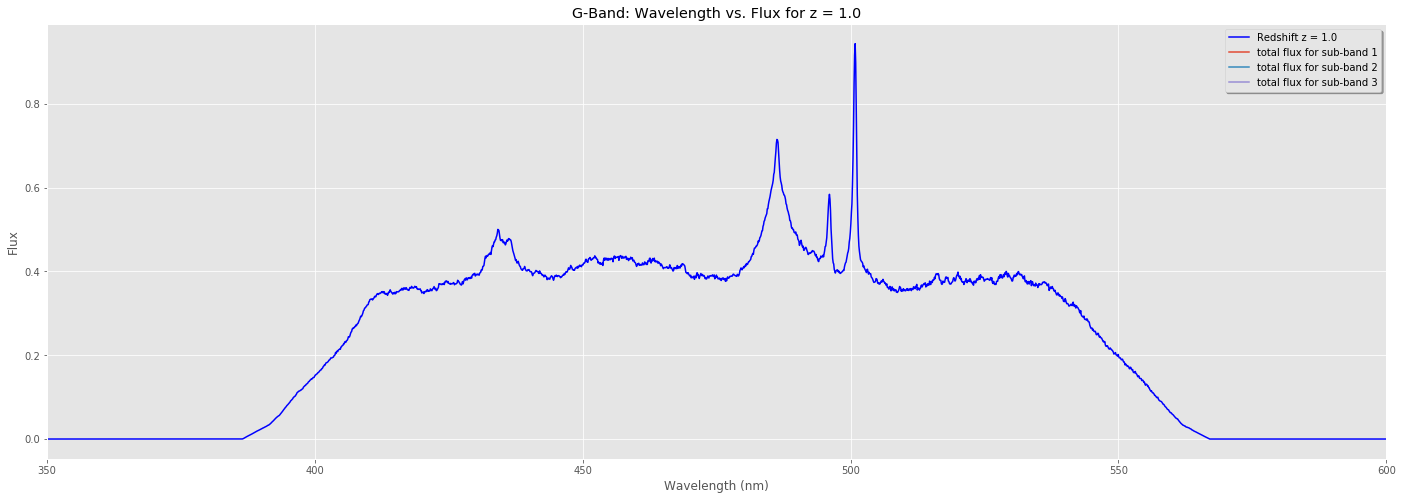

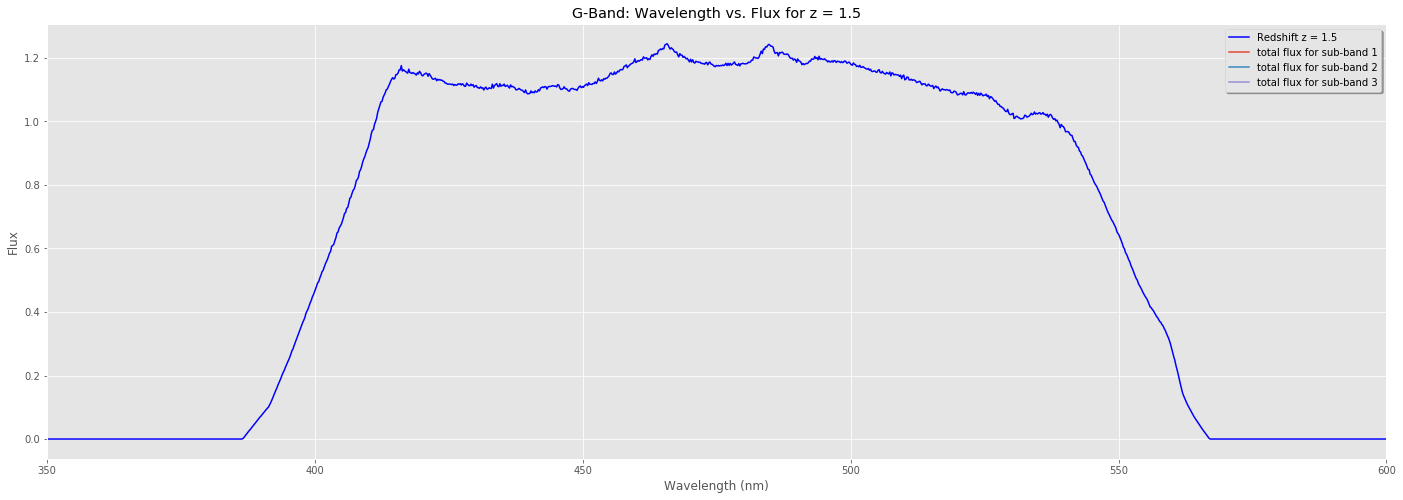

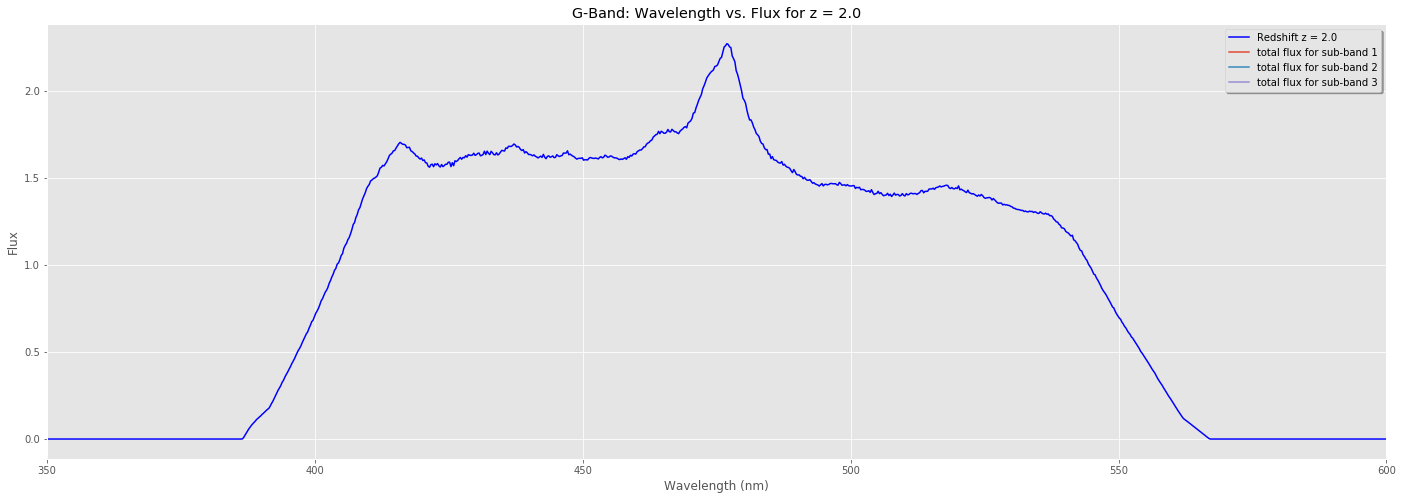

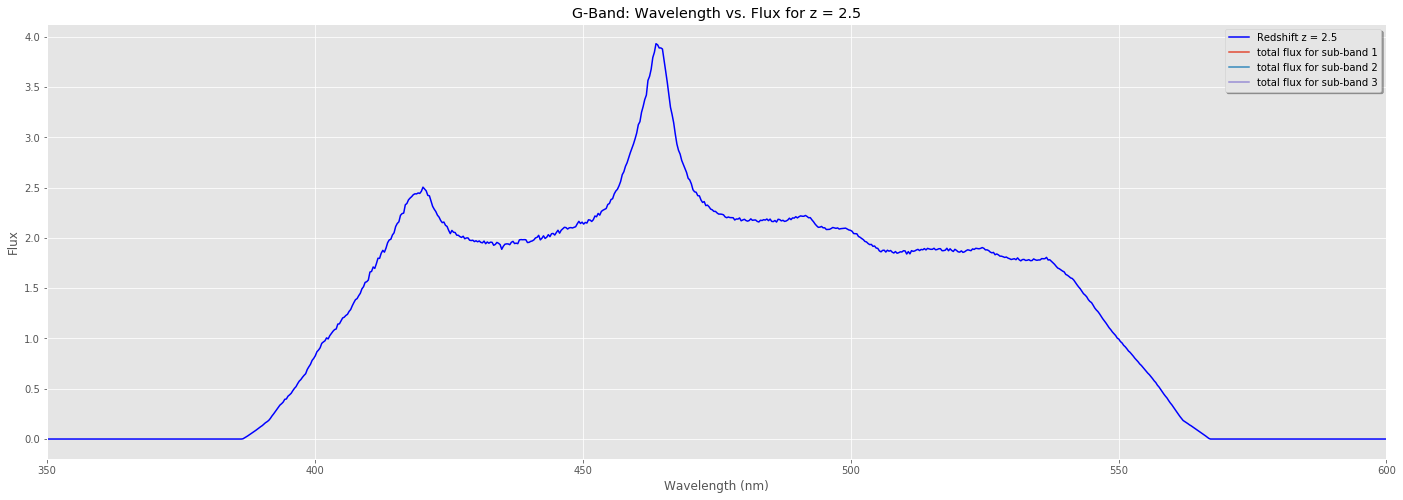

In [17]:
# G-Band Plots
plt.style.use('ggplot')
for z, s in zip(redshifts, spectra_obs):
    fig, ax = plt.subplots (1, 1, figsize = (24,8))
    interpolate = np.interp(s, gband_wavelength[0:7755], gband_throughput[0:7755])
    plt.plot(s, relative_fluxdensity * interpolate, label = 'Redshift z = {}'.format(z), color = 'b')
    
    ax.plot(g1_effective, f1_g / np.sum(gband_wavelength[subband_g_1]), label = 'total flux for sub-band 1')
    ax.plot(g2_effective, f2_g / np.sum(gband_wavelength[subband_g_2]), label = 'total flux for sub-band 2')
    ax.plot(g3_effective, f3_g / np.sum(gband_wavelength[subband_g_3]), label = 'total flux for sub-band 3')
    
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Flux')
    plt.title('G-Band: Wavelength vs. Flux for z = {}'.format(z))
    plt.xlim(350, 600)
    plt.legend(loc = 0, shadow = True);

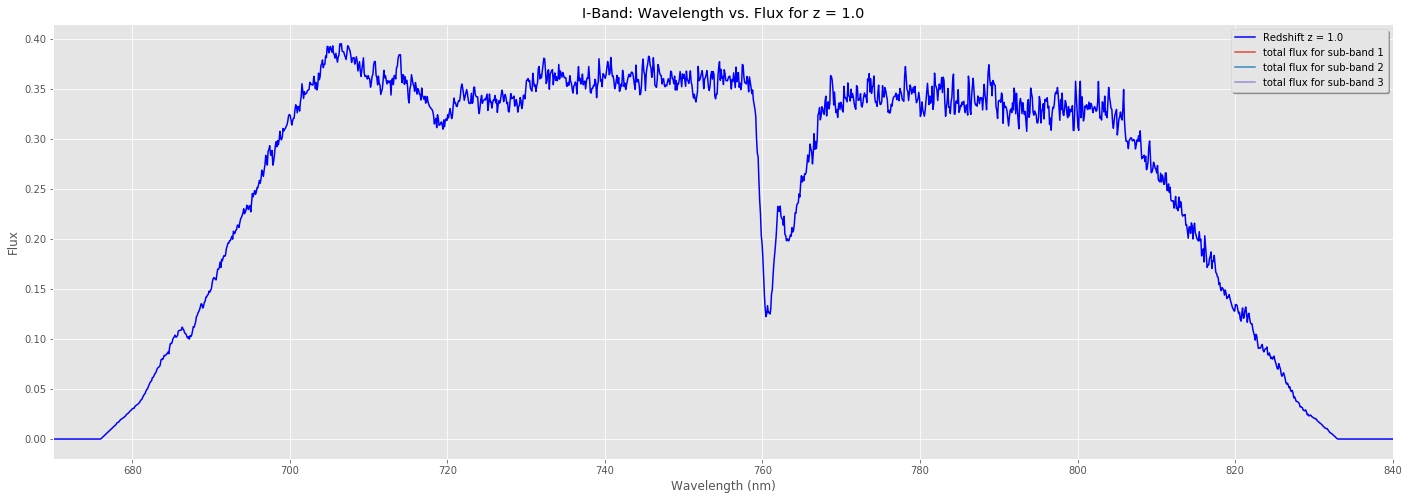

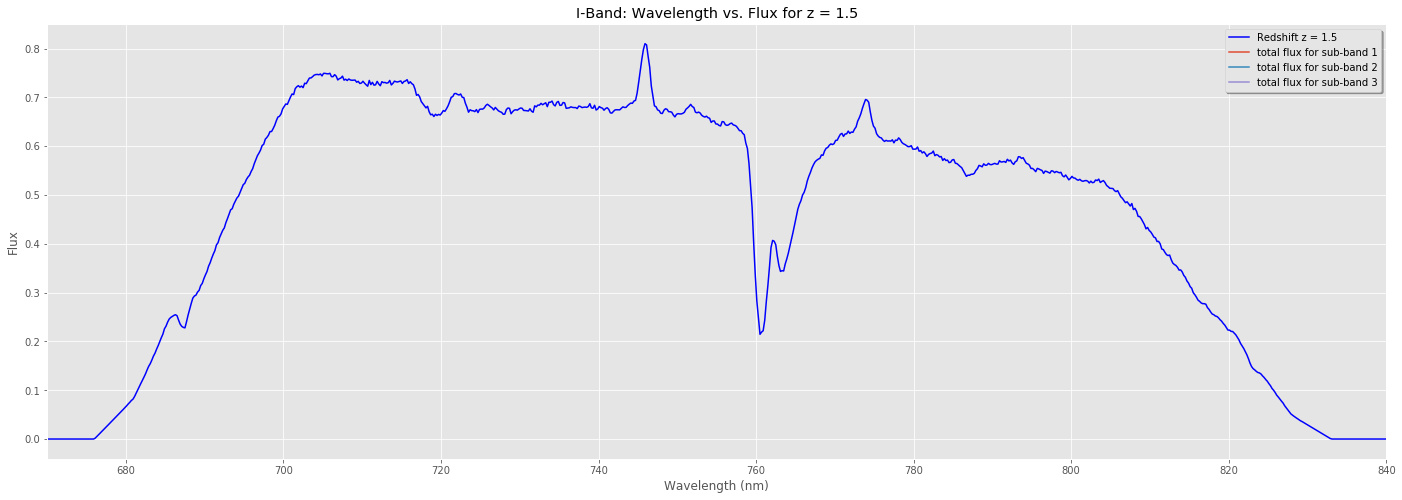

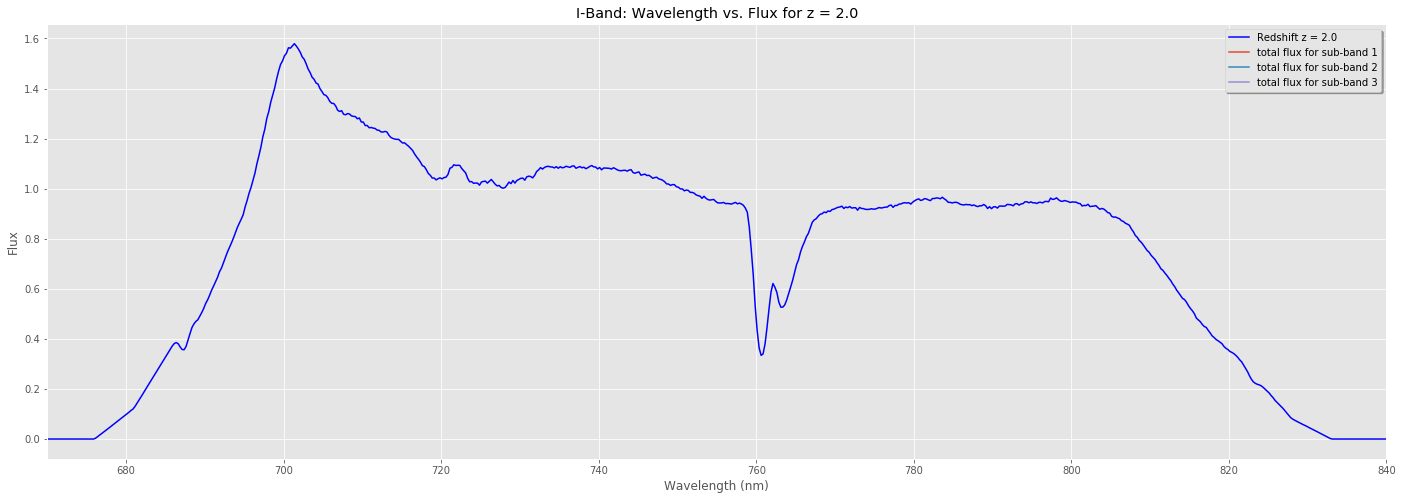

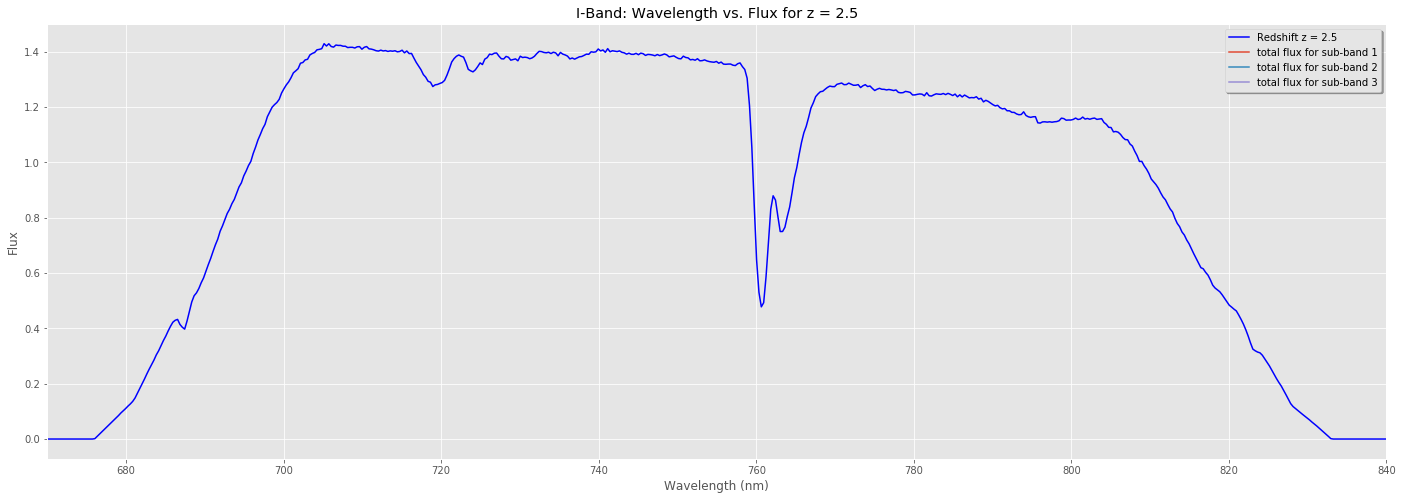

In [18]:
# I-Band Plots
for z, s in zip(redshifts, spectra_obs):
    fig, ax = plt.subplots (1, 1, figsize = (24,8))
    interpolate = np.interp(s, iband_wavelength[0:7755], iband_throughput[0:7755])
    plt.plot(s, relative_fluxdensity * interpolate, label = 'Redshift z = {}'.format(z), color = 'b')
    
    ax.plot(i1_effective, f1_i / np.sum(iband_wavelength[subband_i_1]), label = 'total flux for sub-band 1')
    ax.plot(i2_effective, f2_i / np.sum(iband_wavelength[subband_i_2]), label = 'total flux for sub-band 2')
    ax.plot(i3_effective, f3_i / np.sum(iband_wavelength[subband_i_3]), label = 'total flux for sub-band 3')
    
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Flux')
    plt.title('I-Band: Wavelength vs. Flux for z = {}'.format(z))
    plt.xlim(670, 840)
    plt.legend(loc = 0, shadow = True);

### Part 1b: Calculate the DCR shifts

For each sub-band (of both g- and i-bands), calculate the DCR shift using the effective wavelength of the sub-band with the effective wavelength of the full band as the reference. Report the results in pixels, using the same 0.26 arcseconds/pixel plate scale you used in assignment 2.

In [19]:
def DCR_shift():
    
    dcrshift = 

SyntaxError: invalid syntax (<ipython-input-19-d38bb10f8389>, line 3)

In [ ]:
def DCRshift(subband_effWavelength, effectiveWavelength):
    g_refractionindex_eff = atm_refraction(gWeightedWavelength, p_s, temperature, p_w, latitude, altitude, zin)
    g_difference = (refraction - g_refractionindex_eff) * rad2arcsec

    fig, ax = plt.subplots(1, 1, figsize = (24, 10))
    plt.plot(wavelength_values, g_difference, label = 'g-band', color = 'b')
    ax.set_title('Refraction Difference (arcseconds) vs. Wavelength (nm)', color = 'k', fontsize = 16)
    ax.set_xlabel('Wavelength (nm)', fontstyle = 'italic', color = 'k', fontsize = 16)
    ax.set_ylabel('Refraction Difference (arcseconds)', fontstyle = 'italic', color = 'k', fontsize = 16);

    ax.legend(loc = 0, shadow = True);

In [ ]:
# G-Subband DCR Shifts

g_refractionindex_eff = atm_refraction(gWeightedWavelength, p_s, temperature, p_w, latitude, altitude, zin)
g_difference = (refraction - g_refractionindex_eff) * rad2arcsec

fig, ax = plt.subplots(1, 1, figsize = (24, 10))
plt.plot(wavelength_values, g_difference, label = 'g-band', color = 'b')
ax.set_title('Refraction Difference (arcseconds) vs. Wavelength (nm)', color = 'k', fontsize = 16)
ax.set_xlabel('Wavelength (nm)', fontstyle = 'italic', color = 'k', fontsize = 16)
ax.set_ylabel('Refraction Difference (arcseconds)', fontstyle = 'italic', color = 'k', fontsize = 16);

ax.legend(loc = 0, shadow = True);

In [ ]:
# I-Subband DCR Shifts

### Part 1c: Fit a model

Take the simulated quasar image from assignment 2, 2a and find the best fit to this image using three sub-bands. To do this, model each sub-band as a 2D gaussian, shifted by the amounts you calculated in 1b above. The free parameters are the flux values of each sub-band image (so, a total of three numbers). There are many different ways you could do this fit, so pick one that makes sense to you and we can discuss the benefits and drawbacks of different methods at our meeting.

### Part 1d: Plot the measurements

Take the flux measurements from 1c, and plot them (with different symbols) on top of the plots from 1a above. As you did with the theoretical sub-band fluxes in 1a, normalize the y-axis so that the sub-band measurements, the theoretical sub-band fluxes, and the high-resolution spectra are comparable. It is probably cleanest if you duplicate the plots from 1a.